# Week 3: Kernel Regression, Radial Basis Functions, and Gradient Descent

# Lecture 4: Kernel Regression and Radial Basis Function Expansions

Please see the notes in Canvas for details, but we derived the parameters of a local linear regression model in the neighborhood of the point $x_0$ for $d=1$ by minimizing the weighted squared error loss function,

$$L(\alpha(x_0),\beta(x_0))=\sum\limits_{i=1}^N K_\lambda(x_0,x_i)\left(y_i - \alpha(x_0) - \beta(x_0)x_i\right)^2$$

The function $K_\lambda$ is called a kernel, or weighting, function. Intuitively, it measures how similar two points are. If $x_i$ and $x_0$ are close, the kernel function will be large, so $x_i$ will have a larger impact on the local regression model. A common kernel function is the Gaussian kernel,

$$K_\lambda(x_0,x) = \frac{1}{\lambda}\exp\left(-\frac{\|x-x_0\|_2^2}{2\lambda^2}\right)$$

We found the parameters of the unknown function $f$ in the vicinity of $x_0$ to be

$$\begin{pmatrix} \alpha(x_0) \\ \beta(x_0)\end{pmatrix} = (X^TW(x_0)X)^{-1}X^TW(x_0)y,$$

where

$$X = \begin{pmatrix}1 & x_1\\ 1 & x_2 \\ \vdots & \vdots \\ 1 & x_n\end{pmatrix}, \quad y = \begin{pmatrix}y_1 \\ y_2 \\ \vdots \\ y_n\end{pmatrix}, \quad W(x_0)=\begin{pmatrix}K_\lambda(x_0,x_1) & & & \\ & K_\lambda(x_0,x_2) & & \\ & & \ddots & \\ & & & K_\lambda(x_0,x_n)\end{pmatrix}$$

where $W(x_0)$ is a diagonal matrix, meaning all entries except the diagonal entries are 0.

And, so, the local linear approximation of the unknown function $f$ at $x_0$ is


$$\hat{f}(x_0) = \begin{pmatrix}1 & x_0\end{pmatrix}(X^TW(x_0)X)^{-1}X^TW(x_0)y$$

## Implementing Kernel Regression

Let's write a class that will carry out kernel regression to construct local linear regression models. The class will take the $X$ data, $y$ data, and kernel function as inputs. But, first, let's import some basic things like `NumPy`, `pandas`, `matplotlib`, and some quality metrics for regression models from `scikit-learn`.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

Now, the class.

In [2]:
def GaussianKernel(x0, x, lam):
    return (1/lam) * np.exp(-np.linalg.norm(x0 - x) / (2 * lam))

class KernelRegression:
    def __init__(self, kernel_function, lam, fit_intercept = True):
        self.kernel_function = kernel_function
        self.fit_intercept = fit_intercept
        self.lam = lam

    def predict(self, x0, X, y):
        # find the number of X points
        n = X.shape[0]
        
        # add a column of ones if needed
        if self.fit_intercept:
            X = np.hstack((np.ones([n,1]), X))

        # construct the kernel matrix
        kernel = np.zeros([n, n])
        
        # populate the kernel matrix
        for i in range(n):
            kernel[i][i] = self.kernel_function(x0, X[i,:], self.lam)
                
        return np.array([1, float(x0)]) @ np.linalg.inv((X.T @ kernel @ X)) @ X.T @ kernel @ y

Let's try it with the shampoo dataset from last week. First, read in the data

In [3]:
# read the shampoo sales dataset
data = pd.read_csv('../data/shampoo.csv')

# save the targets
y = data['Sales'].to_numpy()

# make a column vector of 0s with n elements
X = np.zeros([y.shape[0], 1])

# convert the vector to (0, 1, 2, ..., n)
X[:,0] = [i for i in range(y.shape[0])]

# split the data into train and test sets
(trainX, testX, trainY, testY) = train_test_split(X, y, test_size = 0.25, random_state = 1)

Next, let's run the kernel regression model at each x value in a reasonable range using the Gaussian kernel with $\lambda\in\{0.1n:n=1,...,100\}$ and plot each.

In [4]:
lamValues = np.linspace(0.025, 10, 200)

M = lamValues.shape[0]

# allow multiple plots
fig, axes = plt.subplots(nrows = M + 1, figsize = (10, 4*M))

trainMAE = []
testMAE = []

for (j, lam) in enumerate(lamValues):
    model = KernelRegression(GaussianKernel, lam)

    # compute the model coordinates
    xModel = [i for i in range(int(np.round(1.1 * np.max(X))))]
    yModel = [model.predict(i, trainX, trainY) for i in xModel]

    # plot the model
    label = 'Kernel Smoothing for lambda = ' + str(np.round(lam, 2))
    axes[j].scatter(X, y)
    axes[j].plot(xModel, yModel, 'r', label = label)
    axes[j].legend()
    
    # apply the functions to the test data and predict with the model
    trainPredictions = [model.predict(i, trainX, trainY) for i in trainX]
    testPredictions = [model.predict(i, trainX, trainY) for i in testX]
    
    # compute the training and test mean absolute error
    trainError = mean_absolute_error(trainY, trainPredictions)
    testError = mean_absolute_error(testY, testPredictions)
    
    # save the training and test mean absolute error
    trainMAE.append(trainError)
    testMAE.append(testError)

    # return quality metrics
    print('lambda:', np.round(lam, 3), '\t\tr^2:', np.round(r2_score(trainY, trainPredictions), 3),
          '\t\ttrain MAE:', np.round(trainError, 3), '\t\ttest MAE:', np.round(testError, 3))
    
# plot the errors
axes[M].plot(range(M), trainMAE, label = 'Training Mean Absolute Error')
axes[M].plot(range(M), testMAE, label = 'Testing Mean Absolute Error')
axes[M].legend()

C:\Users\rwhite\AppData\Local\Temp\ipykernel_29844\122322261.py:25: RuntimeWarning: invalid value encountered in matmul
  return np.array([1, float(x0)]) @ np.linalg.inv((X.T @ kernel @ X)) @ X.T @ kernel @ y
C:\Users\rwhite\AppData\Local\Temp\ipykernel_29844\122322261.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.array([1, float(x0)]) @ np.linalg.inv((X.T @ kernel @ X)) @ X.T @ kernel @ y
C:\Users\rwhite\AppData\Local\Temp\ipykernel_29844\122322261.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.array([1, float(x0)]) @ np.linalg.inv((X.T @ kernel @ X)) @ X.T @ kernel @ y
C:\Users\rwhite\AppData\Local\Temp\

lambda: 0.025 		r^2: 0.906 		train MAE: 27.749 		test MAE: 62.18
lambda: 0.075 		r^2: 0.854 		train MAE: 37.305 		test MAE: 54.464
lambda: 0.125 		r^2: 0.845 		train MAE: 39.606 		test MAE: 53.2
lambda: 0.175 		r^2: 0.841 		train MAE: 40.842 		test MAE: 52.01
lambda: 0.226 		r^2: 0.838 		train MAE: 41.839 		test MAE: 51.032
lambda: 0.276 		r^2: 0.836 		train MAE: 42.641 		test MAE: 50.217
lambda: 0.326 		r^2: 0.835 		train MAE: 43.305 		test MAE: 49.496
lambda: 0.376 		r^2: 0.833 		train MAE: 43.885 		test MAE: 48.825
lambda: 0.426 		r^2: 0.832 		train MAE: 44.403 		test MAE: 48.178
lambda: 0.476 		r^2: 0.83 		train MAE: 44.873 		test MAE: 47.541
lambda: 0.526 		r^2: 0.828 		train MAE: 45.346 		test MAE: 46.907
lambda: 0.576 		r^2: 0.827 		train MAE: 45.823 		test MAE: 46.274
lambda: 0.627 		r^2: 0.825 		train MAE: 46.262 		test MAE: 45.641
lambda: 0.677 		r^2: 0.824 		train MAE: 46.768 		test MAE: 45.01
lambda: 0.727 		r^2: 0.822 		train MAE: 47.247 		test MAE: 44.382
lambda: 0.777 		

C:\Users\rwhite\AppData\Local\Temp\ipykernel_29844\122322261.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.array([1, float(x0)]) @ np.linalg.inv((X.T @ kernel @ X)) @ X.T @ kernel @ y
C:\Users\rwhite\AppData\Local\Temp\ipykernel_29844\122322261.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.array([1, float(x0)]) @ np.linalg.inv((X.T @ kernel @ X)) @ X.T @ kernel @ y
C:\Users\rwhite\AppData\Local\Temp\ipykernel_29844\122322261.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before perform

lambda: 0.927 		r^2: 0.816 		train MAE: 48.903 		test MAE: 44.264
lambda: 0.977 		r^2: 0.814 		train MAE: 49.264 		test MAE: 44.252
lambda: 1.028 		r^2: 0.813 		train MAE: 49.607 		test MAE: 44.24
lambda: 1.078 		r^2: 0.811 		train MAE: 49.933 		test MAE: 44.227
lambda: 1.128 		r^2: 0.81 		train MAE: 50.244 		test MAE: 44.213
lambda: 1.178 		r^2: 0.808 		train MAE: 50.541 		test MAE: 44.198
lambda: 1.228 		r^2: 0.807 		train MAE: 50.823 		test MAE: 44.182
lambda: 1.278 		r^2: 0.805 		train MAE: 51.093 		test MAE: 44.164
lambda: 1.328 		r^2: 0.804 		train MAE: 51.351 		test MAE: 44.145


C:\Users\rwhite\AppData\Local\Temp\ipykernel_29844\122322261.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.array([1, float(x0)]) @ np.linalg.inv((X.T @ kernel @ X)) @ X.T @ kernel @ y
C:\Users\rwhite\AppData\Local\Temp\ipykernel_29844\122322261.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.array([1, float(x0)]) @ np.linalg.inv((X.T @ kernel @ X)) @ X.T @ kernel @ y
C:\Users\rwhite\AppData\Local\Temp\ipykernel_29844\122322261.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before perform

lambda: 1.378 		r^2: 0.803 		train MAE: 51.597 		test MAE: 44.124
lambda: 1.429 		r^2: 0.801 		train MAE: 51.832 		test MAE: 44.102
lambda: 1.479 		r^2: 0.8 		train MAE: 52.057 		test MAE: 44.078
lambda: 1.529 		r^2: 0.799 		train MAE: 52.272 		test MAE: 44.053
lambda: 1.579 		r^2: 0.797 		train MAE: 52.477 		test MAE: 44.027
lambda: 1.629 		r^2: 0.796 		train MAE: 52.674 		test MAE: 43.999
lambda: 1.679 		r^2: 0.795 		train MAE: 52.862 		test MAE: 43.969
lambda: 1.729 		r^2: 0.794 		train MAE: 53.041 		test MAE: 43.939
lambda: 1.779 		r^2: 0.792 		train MAE: 53.213 		test MAE: 43.907


C:\Users\rwhite\AppData\Local\Temp\ipykernel_29844\122322261.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.array([1, float(x0)]) @ np.linalg.inv((X.T @ kernel @ X)) @ X.T @ kernel @ y
C:\Users\rwhite\AppData\Local\Temp\ipykernel_29844\122322261.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.array([1, float(x0)]) @ np.linalg.inv((X.T @ kernel @ X)) @ X.T @ kernel @ y
C:\Users\rwhite\AppData\Local\Temp\ipykernel_29844\122322261.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before perform

lambda: 1.83 		r^2: 0.791 		train MAE: 53.377 		test MAE: 43.874
lambda: 1.88 		r^2: 0.79 		train MAE: 53.534 		test MAE: 43.84
lambda: 1.93 		r^2: 0.789 		train MAE: 53.684 		test MAE: 43.804
lambda: 1.98 		r^2: 0.788 		train MAE: 53.827 		test MAE: 43.768
lambda: 2.03 		r^2: 0.787 		train MAE: 53.965 		test MAE: 43.73
lambda: 2.08 		r^2: 0.786 		train MAE: 54.096 		test MAE: 43.692
lambda: 2.13 		r^2: 0.785 		train MAE: 54.222 		test MAE: 43.653
lambda: 2.18 		r^2: 0.784 		train MAE: 54.342 		test MAE: 43.613
lambda: 2.231 		r^2: 0.783 		train MAE: 54.457 		test MAE: 43.572
lambda: 2.281 		r^2: 0.782 		train MAE: 54.567 		test MAE: 43.531
lambda: 2.331 		r^2: 0.781 		train MAE: 54.673 		test MAE: 43.489
lambda: 2.381 		r^2: 0.78 		train MAE: 54.774 		test MAE: 43.447
lambda: 2.431 		r^2: 0.779 		train MAE: 54.87 		test MAE: 43.404
lambda: 2.481 		r^2: 0.778 		train MAE: 54.963 		test MAE: 43.36


C:\Users\rwhite\AppData\Local\Temp\ipykernel_29844\122322261.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.array([1, float(x0)]) @ np.linalg.inv((X.T @ kernel @ X)) @ X.T @ kernel @ y
C:\Users\rwhite\AppData\Local\Temp\ipykernel_29844\122322261.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.array([1, float(x0)]) @ np.linalg.inv((X.T @ kernel @ X)) @ X.T @ kernel @ y
C:\Users\rwhite\AppData\Local\Temp\ipykernel_29844\122322261.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before perform

lambda: 2.531 		r^2: 0.777 		train MAE: 55.052 		test MAE: 43.373
lambda: 2.581 		r^2: 0.776 		train MAE: 55.137 		test MAE: 43.403
lambda: 2.632 		r^2: 0.775 		train MAE: 55.218 		test MAE: 43.431
lambda: 2.682 		r^2: 0.774 		train MAE: 55.296 		test MAE: 43.457
lambda: 2.732 		r^2: 0.773 		train MAE: 55.371 		test MAE: 43.481
lambda: 2.782 		r^2: 0.773 		train MAE: 55.443 		test MAE: 43.502
lambda: 2.832 		r^2: 0.772 		train MAE: 55.512 		test MAE: 43.521


C:\Users\rwhite\AppData\Local\Temp\ipykernel_29844\122322261.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.array([1, float(x0)]) @ np.linalg.inv((X.T @ kernel @ X)) @ X.T @ kernel @ y
C:\Users\rwhite\AppData\Local\Temp\ipykernel_29844\122322261.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.array([1, float(x0)]) @ np.linalg.inv((X.T @ kernel @ X)) @ X.T @ kernel @ y
C:\Users\rwhite\AppData\Local\Temp\ipykernel_29844\122322261.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before perform

lambda: 2.882 		r^2: 0.771 		train MAE: 55.578 		test MAE: 43.539
lambda: 2.932 		r^2: 0.77 		train MAE: 55.642 		test MAE: 43.555
lambda: 2.982 		r^2: 0.769 		train MAE: 55.703 		test MAE: 43.569
lambda: 3.033 		r^2: 0.769 		train MAE: 55.761 		test MAE: 43.581
lambda: 3.083 		r^2: 0.768 		train MAE: 55.817 		test MAE: 43.593
lambda: 3.133 		r^2: 0.767 		train MAE: 55.872 		test MAE: 43.603
lambda: 3.183 		r^2: 0.766 		train MAE: 55.924 		test MAE: 43.611
lambda: 3.233 		r^2: 0.766 		train MAE: 55.974 		test MAE: 43.619
lambda: 3.283 		r^2: 0.765 		train MAE: 56.022 		test MAE: 43.625
lambda: 3.333 		r^2: 0.764 		train MAE: 56.068 		test MAE: 43.63
lambda: 3.383 		r^2: 0.764 		train MAE: 56.113 		test MAE: 43.635
lambda: 3.434 		r^2: 0.763 		train MAE: 56.156 		test MAE: 43.638
lambda: 3.484 		r^2: 0.762 		train MAE: 56.197 		test MAE: 43.641


C:\Users\rwhite\AppData\Local\Temp\ipykernel_29844\122322261.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.array([1, float(x0)]) @ np.linalg.inv((X.T @ kernel @ X)) @ X.T @ kernel @ y
C:\Users\rwhite\AppData\Local\Temp\ipykernel_29844\122322261.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.array([1, float(x0)]) @ np.linalg.inv((X.T @ kernel @ X)) @ X.T @ kernel @ y
C:\Users\rwhite\AppData\Local\Temp\ipykernel_29844\122322261.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before perform

lambda: 3.534 		r^2: 0.762 		train MAE: 56.237 		test MAE: 43.642
lambda: 3.584 		r^2: 0.761 		train MAE: 56.276 		test MAE: 43.643
lambda: 3.634 		r^2: 0.76 		train MAE: 56.313 		test MAE: 43.644
lambda: 3.684 		r^2: 0.76 		train MAE: 56.348 		test MAE: 43.643
lambda: 3.734 		r^2: 0.759 		train MAE: 56.396 		test MAE: 43.642
lambda: 3.784 		r^2: 0.758 		train MAE: 56.452 		test MAE: 43.641
lambda: 3.835 		r^2: 0.758 		train MAE: 56.507 		test MAE: 43.639


C:\Users\rwhite\AppData\Local\Temp\ipykernel_29844\122322261.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.array([1, float(x0)]) @ np.linalg.inv((X.T @ kernel @ X)) @ X.T @ kernel @ y
C:\Users\rwhite\AppData\Local\Temp\ipykernel_29844\122322261.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.array([1, float(x0)]) @ np.linalg.inv((X.T @ kernel @ X)) @ X.T @ kernel @ y
C:\Users\rwhite\AppData\Local\Temp\ipykernel_29844\122322261.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before perform

lambda: 3.885 		r^2: 0.757 		train MAE: 56.561 		test MAE: 43.636
lambda: 3.935 		r^2: 0.757 		train MAE: 56.613 		test MAE: 43.634
lambda: 3.985 		r^2: 0.756 		train MAE: 56.665 		test MAE: 43.63
lambda: 4.035 		r^2: 0.755 		train MAE: 56.716 		test MAE: 43.626
lambda: 4.085 		r^2: 0.755 		train MAE: 56.765 		test MAE: 43.622
lambda: 4.135 		r^2: 0.754 		train MAE: 56.813 		test MAE: 43.618
lambda: 4.185 		r^2: 0.754 		train MAE: 56.861 		test MAE: 43.613


C:\Users\rwhite\AppData\Local\Temp\ipykernel_29844\122322261.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.array([1, float(x0)]) @ np.linalg.inv((X.T @ kernel @ X)) @ X.T @ kernel @ y
C:\Users\rwhite\AppData\Local\Temp\ipykernel_29844\122322261.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.array([1, float(x0)]) @ np.linalg.inv((X.T @ kernel @ X)) @ X.T @ kernel @ y
C:\Users\rwhite\AppData\Local\Temp\ipykernel_29844\122322261.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before perform

lambda: 4.236 		r^2: 0.753 		train MAE: 56.907 		test MAE: 43.608
lambda: 4.286 		r^2: 0.753 		train MAE: 56.953 		test MAE: 43.619
lambda: 4.336 		r^2: 0.752 		train MAE: 56.997 		test MAE: 43.648
lambda: 4.386 		r^2: 0.752 		train MAE: 57.041 		test MAE: 43.676
lambda: 4.436 		r^2: 0.751 		train MAE: 57.084 		test MAE: 43.703
lambda: 4.486 		r^2: 0.751 		train MAE: 57.126 		test MAE: 43.729
lambda: 4.536 		r^2: 0.75 		train MAE: 57.167 		test MAE: 43.755
lambda: 4.586 		r^2: 0.749 		train MAE: 57.207 		test MAE: 43.779
lambda: 4.637 		r^2: 0.749 		train MAE: 57.247 		test MAE: 43.803
lambda: 4.687 		r^2: 0.748 		train MAE: 57.286 		test MAE: 43.826


C:\Users\rwhite\AppData\Local\Temp\ipykernel_29844\122322261.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.array([1, float(x0)]) @ np.linalg.inv((X.T @ kernel @ X)) @ X.T @ kernel @ y
C:\Users\rwhite\AppData\Local\Temp\ipykernel_29844\122322261.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.array([1, float(x0)]) @ np.linalg.inv((X.T @ kernel @ X)) @ X.T @ kernel @ y
C:\Users\rwhite\AppData\Local\Temp\ipykernel_29844\122322261.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before perform

lambda: 4.737 		r^2: 0.748 		train MAE: 57.324 		test MAE: 43.848
lambda: 4.787 		r^2: 0.748 		train MAE: 57.362 		test MAE: 43.87
lambda: 4.837 		r^2: 0.747 		train MAE: 57.398 		test MAE: 43.891
lambda: 4.887 		r^2: 0.747 		train MAE: 57.435 		test MAE: 43.911
lambda: 4.937 		r^2: 0.746 		train MAE: 57.47 		test MAE: 43.931
lambda: 4.987 		r^2: 0.746 		train MAE: 57.505 		test MAE: 43.95
lambda: 5.038 		r^2: 0.745 		train MAE: 57.539 		test MAE: 43.969
lambda: 5.088 		r^2: 0.745 		train MAE: 57.573 		test MAE: 43.987
lambda: 5.138 		r^2: 0.744 		train MAE: 57.606 		test MAE: 44.005
lambda: 5.188 		r^2: 0.744 		train MAE: 57.638 		test MAE: 44.022
lambda: 5.238 		r^2: 0.743 		train MAE: 57.67 		test MAE: 44.038
lambda: 5.288 		r^2: 0.743 		train MAE: 57.701 		test MAE: 44.054
lambda: 5.338 		r^2: 0.743 		train MAE: 57.732 		test MAE: 44.07
lambda: 5.388 		r^2: 0.742 		train MAE: 57.762 		test MAE: 44.085


C:\Users\rwhite\AppData\Local\Temp\ipykernel_29844\122322261.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.array([1, float(x0)]) @ np.linalg.inv((X.T @ kernel @ X)) @ X.T @ kernel @ y
C:\Users\rwhite\AppData\Local\Temp\ipykernel_29844\122322261.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.array([1, float(x0)]) @ np.linalg.inv((X.T @ kernel @ X)) @ X.T @ kernel @ y
C:\Users\rwhite\AppData\Local\Temp\ipykernel_29844\122322261.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before perform

lambda: 5.439 		r^2: 0.742 		train MAE: 57.792 		test MAE: 44.1
lambda: 5.489 		r^2: 0.741 		train MAE: 57.822 		test MAE: 44.115
lambda: 5.539 		r^2: 0.741 		train MAE: 57.85 		test MAE: 44.129
lambda: 5.589 		r^2: 0.74 		train MAE: 57.879 		test MAE: 44.142
lambda: 5.639 		r^2: 0.74 		train MAE: 57.907 		test MAE: 44.156
lambda: 5.689 		r^2: 0.74 		train MAE: 57.934 		test MAE: 44.168
lambda: 5.739 		r^2: 0.739 		train MAE: 57.961 		test MAE: 44.181
lambda: 5.789 		r^2: 0.739 		train MAE: 57.988 		test MAE: 44.193


C:\Users\rwhite\AppData\Local\Temp\ipykernel_29844\122322261.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.array([1, float(x0)]) @ np.linalg.inv((X.T @ kernel @ X)) @ X.T @ kernel @ y
C:\Users\rwhite\AppData\Local\Temp\ipykernel_29844\122322261.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.array([1, float(x0)]) @ np.linalg.inv((X.T @ kernel @ X)) @ X.T @ kernel @ y
C:\Users\rwhite\AppData\Local\Temp\ipykernel_29844\122322261.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before perform

lambda: 5.84 		r^2: 0.738 		train MAE: 58.014 		test MAE: 44.205
lambda: 5.89 		r^2: 0.738 		train MAE: 58.039 		test MAE: 44.217
lambda: 5.94 		r^2: 0.738 		train MAE: 58.065 		test MAE: 44.228
lambda: 5.99 		r^2: 0.737 		train MAE: 58.09 		test MAE: 44.239
lambda: 6.04 		r^2: 0.737 		train MAE: 58.115 		test MAE: 44.25
lambda: 6.09 		r^2: 0.737 		train MAE: 58.15 		test MAE: 44.261
lambda: 6.14 		r^2: 0.736 		train MAE: 58.184 		test MAE: 44.271


C:\Users\rwhite\AppData\Local\Temp\ipykernel_29844\122322261.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.array([1, float(x0)]) @ np.linalg.inv((X.T @ kernel @ X)) @ X.T @ kernel @ y
C:\Users\rwhite\AppData\Local\Temp\ipykernel_29844\122322261.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.array([1, float(x0)]) @ np.linalg.inv((X.T @ kernel @ X)) @ X.T @ kernel @ y
C:\Users\rwhite\AppData\Local\Temp\ipykernel_29844\122322261.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before perform

lambda: 6.19 		r^2: 0.736 		train MAE: 58.217 		test MAE: 44.281
lambda: 6.241 		r^2: 0.736 		train MAE: 58.25 		test MAE: 44.291
lambda: 6.291 		r^2: 0.735 		train MAE: 58.283 		test MAE: 44.3
lambda: 6.341 		r^2: 0.735 		train MAE: 58.315 		test MAE: 44.31
lambda: 6.391 		r^2: 0.735 		train MAE: 58.346 		test MAE: 44.319
lambda: 6.441 		r^2: 0.734 		train MAE: 58.378 		test MAE: 44.328
lambda: 6.491 		r^2: 0.734 		train MAE: 58.408 		test MAE: 44.336


C:\Users\rwhite\AppData\Local\Temp\ipykernel_29844\122322261.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.array([1, float(x0)]) @ np.linalg.inv((X.T @ kernel @ X)) @ X.T @ kernel @ y
C:\Users\rwhite\AppData\Local\Temp\ipykernel_29844\122322261.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.array([1, float(x0)]) @ np.linalg.inv((X.T @ kernel @ X)) @ X.T @ kernel @ y
C:\Users\rwhite\AppData\Local\Temp\ipykernel_29844\122322261.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before perform

lambda: 6.541 		r^2: 0.733 		train MAE: 58.439 		test MAE: 44.345
lambda: 6.591 		r^2: 0.733 		train MAE: 58.469 		test MAE: 44.353
lambda: 6.642 		r^2: 0.733 		train MAE: 58.499 		test MAE: 44.361
lambda: 6.692 		r^2: 0.733 		train MAE: 58.528 		test MAE: 44.369
lambda: 6.742 		r^2: 0.732 		train MAE: 58.557 		test MAE: 44.377
lambda: 6.792 		r^2: 0.732 		train MAE: 58.586 		test MAE: 44.384
lambda: 6.842 		r^2: 0.732 		train MAE: 58.614 		test MAE: 44.391


C:\Users\rwhite\AppData\Local\Temp\ipykernel_29844\122322261.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.array([1, float(x0)]) @ np.linalg.inv((X.T @ kernel @ X)) @ X.T @ kernel @ y
C:\Users\rwhite\AppData\Local\Temp\ipykernel_29844\122322261.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.array([1, float(x0)]) @ np.linalg.inv((X.T @ kernel @ X)) @ X.T @ kernel @ y
C:\Users\rwhite\AppData\Local\Temp\ipykernel_29844\122322261.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before perform

lambda: 6.892 		r^2: 0.731 		train MAE: 58.642 		test MAE: 44.399
lambda: 6.942 		r^2: 0.731 		train MAE: 58.669 		test MAE: 44.406
lambda: 6.992 		r^2: 0.731 		train MAE: 58.697 		test MAE: 44.412
lambda: 7.043 		r^2: 0.73 		train MAE: 58.723 		test MAE: 44.419
lambda: 7.093 		r^2: 0.73 		train MAE: 58.75 		test MAE: 44.426
lambda: 7.143 		r^2: 0.73 		train MAE: 58.776 		test MAE: 44.432
lambda: 7.193 		r^2: 0.729 		train MAE: 58.802 		test MAE: 44.438


C:\Users\rwhite\AppData\Local\Temp\ipykernel_29844\122322261.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.array([1, float(x0)]) @ np.linalg.inv((X.T @ kernel @ X)) @ X.T @ kernel @ y
C:\Users\rwhite\AppData\Local\Temp\ipykernel_29844\122322261.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.array([1, float(x0)]) @ np.linalg.inv((X.T @ kernel @ X)) @ X.T @ kernel @ y
C:\Users\rwhite\AppData\Local\Temp\ipykernel_29844\122322261.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before perform

lambda: 7.243 		r^2: 0.729 		train MAE: 58.828 		test MAE: 44.445
lambda: 7.293 		r^2: 0.729 		train MAE: 58.853 		test MAE: 44.451
lambda: 7.343 		r^2: 0.729 		train MAE: 58.878 		test MAE: 44.456
lambda: 7.393 		r^2: 0.728 		train MAE: 58.903 		test MAE: 44.462
lambda: 7.444 		r^2: 0.728 		train MAE: 58.927 		test MAE: 44.468
lambda: 7.494 		r^2: 0.728 		train MAE: 58.951 		test MAE: 44.473


C:\Users\rwhite\AppData\Local\Temp\ipykernel_29844\122322261.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.array([1, float(x0)]) @ np.linalg.inv((X.T @ kernel @ X)) @ X.T @ kernel @ y
C:\Users\rwhite\AppData\Local\Temp\ipykernel_29844\122322261.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.array([1, float(x0)]) @ np.linalg.inv((X.T @ kernel @ X)) @ X.T @ kernel @ y
C:\Users\rwhite\AppData\Local\Temp\ipykernel_29844\122322261.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before perform

lambda: 7.544 		r^2: 0.727 		train MAE: 58.975 		test MAE: 44.479
lambda: 7.594 		r^2: 0.727 		train MAE: 58.999 		test MAE: 44.484
lambda: 7.644 		r^2: 0.727 		train MAE: 59.022 		test MAE: 44.489
lambda: 7.694 		r^2: 0.727 		train MAE: 59.045 		test MAE: 44.494
lambda: 7.744 		r^2: 0.726 		train MAE: 59.068 		test MAE: 44.499
lambda: 7.794 		r^2: 0.726 		train MAE: 59.091 		test MAE: 44.504
lambda: 7.845 		r^2: 0.726 		train MAE: 59.113 		test MAE: 44.509


C:\Users\rwhite\AppData\Local\Temp\ipykernel_29844\122322261.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.array([1, float(x0)]) @ np.linalg.inv((X.T @ kernel @ X)) @ X.T @ kernel @ y
C:\Users\rwhite\AppData\Local\Temp\ipykernel_29844\122322261.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.array([1, float(x0)]) @ np.linalg.inv((X.T @ kernel @ X)) @ X.T @ kernel @ y
C:\Users\rwhite\AppData\Local\Temp\ipykernel_29844\122322261.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before perform

lambda: 7.895 		r^2: 0.726 		train MAE: 59.135 		test MAE: 44.513
lambda: 7.945 		r^2: 0.725 		train MAE: 59.157 		test MAE: 44.518
lambda: 7.995 		r^2: 0.725 		train MAE: 59.179 		test MAE: 44.522
lambda: 8.045 		r^2: 0.725 		train MAE: 59.2 		test MAE: 44.527
lambda: 8.095 		r^2: 0.725 		train MAE: 59.221 		test MAE: 44.531


C:\Users\rwhite\AppData\Local\Temp\ipykernel_29844\122322261.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.array([1, float(x0)]) @ np.linalg.inv((X.T @ kernel @ X)) @ X.T @ kernel @ y
C:\Users\rwhite\AppData\Local\Temp\ipykernel_29844\122322261.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.array([1, float(x0)]) @ np.linalg.inv((X.T @ kernel @ X)) @ X.T @ kernel @ y
C:\Users\rwhite\AppData\Local\Temp\ipykernel_29844\122322261.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before perform

lambda: 8.145 		r^2: 0.724 		train MAE: 59.242 		test MAE: 44.535
lambda: 8.195 		r^2: 0.724 		train MAE: 59.263 		test MAE: 44.539
lambda: 8.246 		r^2: 0.724 		train MAE: 59.283 		test MAE: 44.543
lambda: 8.296 		r^2: 0.724 		train MAE: 59.303 		test MAE: 44.547
lambda: 8.346 		r^2: 0.723 		train MAE: 59.323 		test MAE: 44.551
lambda: 8.396 		r^2: 0.723 		train MAE: 59.343 		test MAE: 44.555
lambda: 8.446 		r^2: 0.723 		train MAE: 59.363 		test MAE: 44.559


C:\Users\rwhite\AppData\Local\Temp\ipykernel_29844\122322261.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.array([1, float(x0)]) @ np.linalg.inv((X.T @ kernel @ X)) @ X.T @ kernel @ y
C:\Users\rwhite\AppData\Local\Temp\ipykernel_29844\122322261.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.array([1, float(x0)]) @ np.linalg.inv((X.T @ kernel @ X)) @ X.T @ kernel @ y
C:\Users\rwhite\AppData\Local\Temp\ipykernel_29844\122322261.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before perform

lambda: 8.496 		r^2: 0.723 		train MAE: 59.382 		test MAE: 44.562
lambda: 8.546 		r^2: 0.722 		train MAE: 59.401 		test MAE: 44.566
lambda: 8.596 		r^2: 0.722 		train MAE: 59.42 		test MAE: 44.57
lambda: 8.647 		r^2: 0.722 		train MAE: 59.439 		test MAE: 44.573
lambda: 8.697 		r^2: 0.722 		train MAE: 59.458 		test MAE: 44.576
lambda: 8.747 		r^2: 0.721 		train MAE: 59.476 		test MAE: 44.58
lambda: 8.797 		r^2: 0.721 		train MAE: 59.494 		test MAE: 44.583


C:\Users\rwhite\AppData\Local\Temp\ipykernel_29844\122322261.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.array([1, float(x0)]) @ np.linalg.inv((X.T @ kernel @ X)) @ X.T @ kernel @ y
C:\Users\rwhite\AppData\Local\Temp\ipykernel_29844\122322261.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.array([1, float(x0)]) @ np.linalg.inv((X.T @ kernel @ X)) @ X.T @ kernel @ y
C:\Users\rwhite\AppData\Local\Temp\ipykernel_29844\122322261.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before perform

lambda: 8.847 		r^2: 0.721 		train MAE: 59.512 		test MAE: 44.586
lambda: 8.897 		r^2: 0.721 		train MAE: 59.53 		test MAE: 44.589
lambda: 8.947 		r^2: 0.721 		train MAE: 59.548 		test MAE: 44.592
lambda: 8.997 		r^2: 0.72 		train MAE: 59.566 		test MAE: 44.596
lambda: 9.048 		r^2: 0.72 		train MAE: 59.583 		test MAE: 44.598
lambda: 9.098 		r^2: 0.72 		train MAE: 59.6 		test MAE: 44.601


C:\Users\rwhite\AppData\Local\Temp\ipykernel_29844\122322261.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.array([1, float(x0)]) @ np.linalg.inv((X.T @ kernel @ X)) @ X.T @ kernel @ y
C:\Users\rwhite\AppData\Local\Temp\ipykernel_29844\122322261.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.array([1, float(x0)]) @ np.linalg.inv((X.T @ kernel @ X)) @ X.T @ kernel @ y
C:\Users\rwhite\AppData\Local\Temp\ipykernel_29844\122322261.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before perform

lambda: 9.148 		r^2: 0.72 		train MAE: 59.617 		test MAE: 44.604
lambda: 9.198 		r^2: 0.719 		train MAE: 59.634 		test MAE: 44.607
lambda: 9.248 		r^2: 0.719 		train MAE: 59.651 		test MAE: 44.61
lambda: 9.298 		r^2: 0.719 		train MAE: 59.667 		test MAE: 44.613
lambda: 9.348 		r^2: 0.719 		train MAE: 59.683 		test MAE: 44.615
lambda: 9.398 		r^2: 0.719 		train MAE: 59.7 		test MAE: 44.618
lambda: 9.449 		r^2: 0.718 		train MAE: 59.716 		test MAE: 44.62
lambda: 9.499 		r^2: 0.718 		train MAE: 59.732 		test MAE: 44.623
lambda: 9.549 		r^2: 0.718 		train MAE: 59.747 		test MAE: 44.625
lambda: 9.599 		r^2: 0.718 		train MAE: 59.763 		test MAE: 44.628
lambda: 9.649 		r^2: 0.718 		train MAE: 59.778 		test MAE: 44.63
lambda: 9.699 		r^2: 0.717 		train MAE: 59.794 		test MAE: 44.633
lambda: 9.749 		r^2: 0.717 		train MAE: 59.809 		test MAE: 44.635
lambda: 9.799 		r^2: 0.717 		train MAE: 59.824 		test MAE: 44.637
lambda: 9.85 		r^2: 0.717 		train MAE: 59.839 		test MAE: 44.639


C:\Users\rwhite\AppData\Local\Temp\ipykernel_29844\122322261.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.array([1, float(x0)]) @ np.linalg.inv((X.T @ kernel @ X)) @ X.T @ kernel @ y
C:\Users\rwhite\AppData\Local\Temp\ipykernel_29844\122322261.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.array([1, float(x0)]) @ np.linalg.inv((X.T @ kernel @ X)) @ X.T @ kernel @ y
C:\Users\rwhite\AppData\Local\Temp\ipykernel_29844\122322261.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before perform

lambda: 9.9 		r^2: 0.717 		train MAE: 59.854 		test MAE: 44.642
lambda: 9.95 		r^2: 0.717 		train MAE: 59.868 		test MAE: 44.644
lambda: 10.0 		r^2: 0.716 		train MAE: 59.883 		test MAE: 44.646


C:\Users\rwhite\AppData\Local\Temp\ipykernel_29844\122322261.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.array([1, float(x0)]) @ np.linalg.inv((X.T @ kernel @ X)) @ X.T @ kernel @ y


Error in callback <function _draw_all_if_interactive at 0x00000297F46DAFC0> (for post_execute), with arguments args (),kwargs {}:


ValueError: Image size of 1000x80000 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 1000x80000 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1000x80000 with 201 Axes>

As you can see, with a smaller $\lambda$ value, the fitted curve has some very sharp curves as the nearby points exert a pulling force on the locally linear curve. But, as we increase $\lambda$, the more smoothing we see in the predicted curve--as points further away from the input $x_0$ have more impact. Increasing $\lambda$ results in smoother and smoother curves (hence, the name kernel *smoothing*), which become nearer to a linear fit.

Beyond that, a larger $\lambda$ continually increases the training error and reduces the $r^2$, but the testing error, the more important measure, is reduced to at $\lambda=2.554$, but then starts to increase.

# Lecture 5: Implementing Gradient Descent for Regression

Today, we will focus on implementing gradient descent using basic `NumPy`. Gradient descent is a general-purpose optimization algorithm, but we will start by using it for some regression problems using some methods we have developed in the class so far.

### Some Ideas from Multivariate Calculus

First, we need just a few ideas from multivariate calculus. This is quite minimal, but you learn more details about these topics in sections 4.3 (partial derivatives), 4.6 (gradients), and 4.7 (multivariate optimization) of <a href="https://openstax.org/details/books/calculus-volume-3">*Calculus Volume 3*</a> by Strang.

The ideas we need for gradient descent include:

* If we have a differentiable function of several variables, like our loss function $L(\theta) = L(\theta_0, ..., \theta_d)$, we can define the **partial derivatives** with respect to each of these variables as

    $$L_{\theta_i}=\frac{\partial L}{\partial \theta_i}=\lim\limits_{h\to 0}\frac{L(\theta+he_i) - L(\theta)}{h},$$

    where $e_i$ is a $(d+1)$-vector with all 0s except for a 1 in the $i$th component.  Geometrically, this partial derivative is the slope of $L$ if we go in the direction of $e_i$.
    
* To **minimize a multivariable function** by hand, we need to find critical points, which are points $\theta$ where *all* partial derivatives are 0 and compare which ones give the lowest outputs. In numerical algorithms, must settle for approximations that are "nearly" critical points.
    
* If we put these partial derivatives into a vector of $d+1$ variables, we call that a **gradient**, which we denote
    
    $$
    \nabla L(\theta)
    =\begin{pmatrix}
    L_{\theta_0}(\theta) \\
    \vdots \\
    L_{\theta_d}(\theta)
    \end{pmatrix}
    $$
    
* The **directional derivative** of a function in the direction of a unit vector $u$ starting from a point $\theta$.

$$D_u L(\theta) = \lim\limits_{h\to 0}\frac{L(\theta+hu) - L(\theta)}{h},$$
    
which is the slope in the direction of the vector $u$. Since $L$ is differentiable, this directional derivative will be defined for all directions leaving from $\theta$. In 1D, there are just two directions: left of right. In 2D, we have directional derivatives at every angle in a circle around the point.

* A common theorem says the **directional derivative is maximized in the direction of the gradient** at each point, so the gradient gives the direction of the *steepest ascent* in the function $L$. Similarly, the direction of the *steepest descent* is $-\nabla L(\theta)$, the opposite direction.

### The Geometry of Gradient Descent

We will discuss the geometry of gradient-based methods in class, but let's discuss a general outline of how gradient descent works, setting aside the stochastic version for now. The goal of gradient descent is to approximately solve the minimization problem

$$\min\limits_{\theta}\,L(\theta)$$

by finding (approximate) critical values by making a guess for the location of a critical value, taking a small step in the opposite direction as the gradient, and repeating this over and over until, hopefully, we reach a minimum value.

The steps are:

0. Make a guess for the critical value -- $\theta^0$
1. Compute the gradient of $L$ at $\theta^0$
2. Take a small step to $\theta^1 = \theta^0 - \alpha\nabla L\left(\theta^0\right)$
3. Compute the gradient of $L$ at $\theta^1$
4. Take a small step to $\theta^2 = \theta^1 - \alpha\nabla L\left(\theta^1\right)$
5. (repeat until the gradient gets close to $(0, ..., 0)$)

This $\alpha>0$ is a number that will be used in the algorithm as a multiplier of the steps the method will take. This is called the **learning rate**.

This idea seems plausible from the calculus ideas above because we just keep switching directions and making a step in the direction of the steepest downward path--the opposite direction as the gradient--until we reach a good place. This is a "greedy" algorithm because it just picks the quickest step in each iteration, which is fast, but it is likely to land in the first minimum it finds, which may or may not be optimal.

If you had two parameters, $L$ would be like a 3D curved surface. A nice visual to have in mind is a rain drop falling on a huge leaf. The droplet of water will move in the steepest downward direction due to gravity--but this direction *changes* as the drip follows the contours of the leaf. This is what gradient descent does.

Will the drip land in the physically lowest altitude part of the leaf? Maybe, but maybe not. If the rain drop lands on the edge, it will probably just roll off the edge. If the leaf has a few different "sinks," different initial locations of the rain drop might cause it to land in these different ones, some of which have lower altitudes than others. Now, if there is heavy rain and lots of rain drops land on the leaf, we can be pretty sure *some* of them will reach the lowest-altitude sink.

From this analogy, you might get the idea that we can make several initial guesses and run it to be more confident we will find the global minimum and not just a local minimum.

In the end, if some of our initial guesses are good choices, the step size $\alpha$ is not too big or too small, and the loss function is pretty well-behaved, the method will converge approximately to a local minimum.

### Implementing Gradient Descent

Let's import some libraries then write a function for gradient descent.

In [5]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

Gradient descent will need a few inputs:

* A function to minimize $f$
* A starting point $x_0$
* A learning rate $\alpha$
* A small number $h$ (the variable that goes to 0 in the definition of the derivative)
* A small positive value that we can use for a stopping condition for the derivative being sufficiently small (the tolerance)
* A maximum number of iterations

In [6]:
def computeGradient(f, x, h):
    # create a zero vector for the gradient
    n = len(x)
    gradient = np.zeros(n)
    
    # save f(x) so we don't need to compute it so frequently
    fx = f(x)
    
    # approximate the gradient
    for i in range(n):
        xUp = x.copy()
        
        # add h to the ith component of x
        xUp[i] += h
        
        # approximate the ith partial derivative
        gradient[i] = (f(xUp) - fx)/h
            
    return gradient

# run gradient descent and output the 
def gradientDescent(f, x0, alpha, h, tolerance, maxIterations):
    # set x equal to the initial guess
    x = x0
                
    # take up to maxIterations number of steps
    for counter in range(maxIterations):
        # update the gradient
        gradient = computeGradient(f, x, h)
        
        # stop if the norm of the gradient is near 0
        if np.linalg.norm(gradient) < tolerance:
            #print('Gradient descent took', counter, 'iterations to converge')
            #print('The norm of the gradient is', np.linalg.norm(gradient))
            # return the approximate critical value x
            return x
        
        # if we do not converge, print a message
        elif counter == maxIterations-1:
            #print("Gradient descent failed")
            #print('The gradient is', gradient)
            # return x, sometimes it is still pretty good
            return x
        
        # take a step in the opposite direction as the gradient
        x -= alpha*gradient

### OLS by Gradient Descent

Ideally, we want to use gradient descent for radial basis function expansions, for which we were unable to find an explicit formula for model parameters because the loss function does not have a unique solution, but let's start with a simpler problem: finding an approximate solution for the ordinary least squares problem.

Recall that, in this situation, we have some labeled datapoints $(x_{i1}, ..., x_{id}, y_i)$, where we fit a function of the form

$$f_\theta(x_i) = \theta_0 + \sum\limits_{j=1}^d\theta_jx_{ij}$$

To find the least squares solution, we aim to solve the minimization problem $\min\limits_\theta L(\theta)$ for $\theta=(\theta_0, \theta_1, ..., \theta_d)\in\mathbb{R}^{d+1}$, where the loss function is

$$L(\theta)=\sum\limits_{i=1}^n \left(y_i - f_\theta(x_i)\right)^2=\sum\limits_{i=1}^n \left(y_i - \theta_0 - \sum\limits_{j=1}^d\theta_jx_{ij}\right)^2$$

Let's bring in our exact OLS class for linear regression from Week 1.

In [7]:
class OrdinaryLeastSquaresExact:
        
    # fit the model to the data
    def fit(self, X, y):
        # save the training data
        self.data = np.hstack((np.ones([X.shape[0],1]), X))
        
        # save the training labels
        self.output = y
        
        # find the theta values that minimize the sum of squared errors
        X = self.data
        self.theta = np.linalg.inv(X.T @ X) @ X.T @ y
                
    # predict the output from input (testing) data
    def predict(self, X):
        # initialize an empty matrix to store the predicted outputs
        yPredicted = np.empty([X.shape[0],1])
        
        # append a column of ones at the beginning of X
        X = np.hstack((np.ones([X.shape[0],1]), X))
        
        # apply the function f with the values of theta from the fit function to each testing datapoint
        for row in range(X.shape[0]):
            yPredicted[row] = self.theta @ X[row,]
            
        return yPredicted

In addition, let's write an OLS class using gradient descent instead.

In [8]:
class OrdinaryLeastSquaresGradient:
        
    # fit the model to the data
    def fit(self, X, y, x0, alpha, h, tolerance, maxIterations):
        self.n = X.shape[0]
        self.d = X.shape[1]
        self.h = h
        self.alpha = alpha
        self.initialGuess = x0
        
        # save the training data
        self.data = np.hstack((np.ones([self.n, 1]), X))
        
        # save the training labels
        self.output = y
        
        # find the theta values that minimize the sum of squared errors via gradient descent
        X = self.data
        L = lambda theta: ((X @ theta).T - y.T) @ (X @ theta - y)
        self.theta = gradientDescent(L, self.initialGuess, self.alpha, self.h, tolerance, maxIterations)
                
    # predict the output from testing data
    def predict(self, X):
        # initialize an empty matrix to store the predicted outputs
        yPredicted = np.empty([X.shape[0],1])
        
        # append a column of ones at the beginning of X
        X = np.hstack((np.ones([X.shape[0],1]), X))
        
        # apply the function f with the values of theta from the fit function to each testing datapoint (rows of X)
        for row in range(X.shape[0]):
            yPredicted[row] = self.theta @ X[row,]
            
        return yPredicted

### 1D Example (Revisited)

FOR THE GRADIENT-BASED ORDINARY LEAST SQUARES CODE

The predicted y values are [1.88927362 2.39728623 2.90529883 3.41331144 2.39728623]
The real y values are [1 2 3 3 4]
The theta values are [-1.15880201  0.5080126 ]
The r^2 score is 0.2890134587732638
The mean absolute error is 0.6794572453892247 

FOR THE EXACT ORDINARY LEAST SQUARES CODE 

The predicted y values are [1.84615385 2.38461538 2.92307692 3.46153846 2.38461538]
The real y values are [1 2 3 3 4]
The theta values are [-1.38461538  0.53846154]
The r^2 score is 0.289940828402367
The mean absolute error is 0.6769230769230757


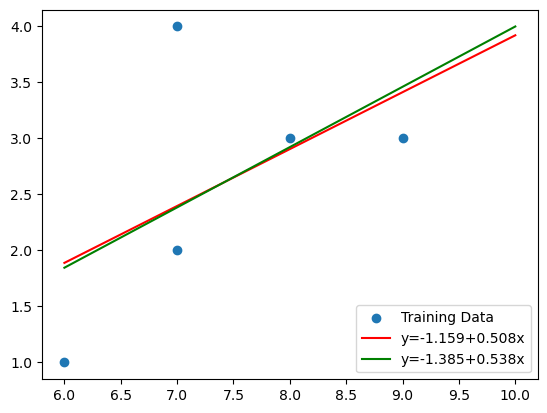

In [9]:
X = np.array([[6], [7], [8], [9], [7]])
y = np.array([1, 2, 3, 3, 4])

print('FOR THE GRADIENT-BASED ORDINARY LEAST SQUARES CODE')

# instantiate an OLS (gradient) object, fit to data, predict data
model = OrdinaryLeastSquaresGradient()
model.fit(X, y, [0, 0], alpha = 0.001, h = 0.001, tolerance = 0.01, maxIterations = 100000)
predictions = model.predict(X)

# print the predictions
print('\nThe predicted y values are', predictions.T[0])

# print the real y values
print('The real y values are', y)

# print the theta values
parameters = model.theta
print('The theta values are', parameters)

# plot the training points
plt.scatter(X, y, label = 'Training Data')

# plot the fitted model with the training data
xModel = np.linspace(6,10,100)
yModel = parameters[0] + parameters[1]*xModel
lineFormula = 'y={:.3f}+{:.3f}x'.format(parameters[0], parameters[1])
plt.plot(xModel, yModel, 'r', label = lineFormula)

# add a legend
plt.legend()

# return quality metrics
print('The r^2 score is', r2_score(y, predictions))
print('The mean absolute error is', mean_absolute_error(y, predictions),'\n')

###################################################################################

print('FOR THE EXACT ORDINARY LEAST SQUARES CODE \n')

# instantiate an OLS (exact) object, fit to data, predict data
model = OrdinaryLeastSquaresExact()
model.fit(X,y)
predictions = model.predict(X)

# print the predictions
print('The predicted y values are', predictions.T[0])

# print the real y values
print('The real y values are', y)

# print the theta values
parameters = model.theta
print('The theta values are', parameters)

# plot the fitted model with the training data
xModel = np.linspace(6,10,100)
yModel = parameters[0] + parameters[1]*xModel
lineFormula = 'y={:.3f}+{:.3f}x'.format(parameters[0], parameters[1])
plt.plot(xModel, yModel, 'g', label = lineFormula)

# add a legend
plt.legend()

# return quality metrics
print('The r^2 score is', r2_score(y, predictions))
print('The mean absolute error is', mean_absolute_error(y, predictions))

## 2D Example (Revisited)

In [10]:
trainX = np.array([[2, 2], [2, 3], [5, 6], [6, 7], [9, 10]])
trainY = np.array([3, 13, 19, 29, 35])

testX = np.array([[2, 1], [4, 5], [6, 5], [8, 9]])
testY = np.array([9, 15, 25, 31])

print('FOR THE GRADIENT-BASED ORDINARY LEAST SQUARES CODE \n')

# instantiate an OLS model
model = OrdinaryLeastSquaresGradient()

# fit the model to the training data (find the theta parameters)
model.fit(trainX, trainY, [0, 0, 0], alpha = 0.001, h = 0.001, tolerance = 0.01, maxIterations = 100000)

# return the predicted outputs for the datapoints in the training set
trainPredictions = model.predict(trainX)

# print the coefficient of determination r^2
print('The r^2 score is', r2_score(trainY, trainPredictions))

# print quality metrics
print('The mean absolute error on the training set is', mean_absolute_error(trainY, trainPredictions))

# return the predicted outputs for the datapoints in the test set
predictions = model.predict(testX)

# print the predictions
print('The predicted y values for the test set are', predictions.T[0])

# print the real y values
print('The real y values for the test set are', testY)

# print the theta values
thetaApprox = model.theta
print('The theta values are', thetaApprox)

# print quality metrics
print('The mean absolute error on the test set is', mean_absolute_error(testY, predictions), '\n')

##############################################################################################

print('FOR THE EXACT ORDINARY LEAST SQUARES CODE \n')

# instantiate an OLS model
model = OrdinaryLeastSquaresExact()

# fit the model to the training data (find the theta parameters)
model.fit(trainX, trainY)

# return the predicted outputs for the datapoints in the training set
trainPredictions = model.predict(trainX)

# print the coefficient of determination r^2
print('The r^2 score is', r2_score(trainY, trainPredictions))

# print quality metrics
print('The mean absolute error on the training set is', mean_absolute_error(trainY, trainPredictions))

# return the predicted outputs for the datapoints in the test set
predictions = model.predict(testX)

# print the predictions
print('The predicted y values for the test set are', predictions.T[0])

# print the real y values
print('The real y values for the test set are', testY)

# print the theta values
thetaExact = model.theta
print('The theta values are', thetaExact)

# print quality metrics
print('The mean absolute error on the test set is', mean_absolute_error(testY, predictions))

FOR THE GRADIENT-BASED ORDINARY LEAST SQUARES CODE 

The r^2 score is 0.9642661609185357
The mean absolute error on the training set is 1.5437720794090986
The predicted y values for the test set are [-6.44748058 19.07004759  6.67858093 32.19610911]
The real y values for the test set are [ 9 15 25 31]
The theta values are [-3.53326263 -6.19573333  9.47724871]
The mean absolute error on the test set is 9.758764086774462 

FOR THE EXACT ORDINARY LEAST SQUARES CODE 

The r^2 score is 0.9642679900744415
The mean absolute error on the training set is 1.5360000000000298
The predicted y values for the test set are [-6.52 19.08  6.6  32.2 ]
The real y values for the test set are [ 9 15 25 31]
The theta values are [-3.56 -6.24  9.52]
The mean absolute error on the test set is 9.799999999999962


## Example: High School Graduate Rates in the US (Revisited)

In [11]:
# import the data from the csv file to an numpy array
data = pd.read_csv('../data/US_State_Data.csv', sep=',').to_numpy()

X = np.array(data[:,1:8], dtype=float)
y = np.array(data[:,8], dtype=float)

# split the data into training and test sets
(trainX, testX, trainY, testY) = train_test_split(X, y, test_size = 0.25, random_state = 1)

# standardize the data
trainX = scale(trainX)
testX = scale(testX)

print('FOR THE GRADIENT-BASED ORDINARY LEAST SQUARES CODE')

# instantiate an OLS model
model = OrdinaryLeastSquaresGradient()

# fit the model to the training data (find the theta parameters)
model.fit(trainX, trainY, [0, 0, 0, 0, 0, 0, 0, 0], alpha = 0.001, h = 0.001, tolerance = 0.01, maxIterations = 100000)

# return the predicted outputs for the datapoints in the training set
trainPredictions = model.predict(trainX)

# print the coefficient of determination r^2
print('\nThe r^2 score is', r2_score(trainY, trainPredictions))

# print quality metrics
print('The mean absolute error on the training set is', mean_absolute_error(trainY, trainPredictions))

# return the predicted outputs for the datapoints in the test set
predictions = model.predict(testX)

# print the predictions
print('The predicted y values for the test set are', np.round(predictions.T[0],0))

# print the real y values
print('The real y values for the test set are     ', testY)

# print the theta values
print('The theta values are', model.theta)

# print quality metrics
print('The mean absolute error on the test set is', mean_absolute_error(testY, predictions), '\n')

##################################################################

print('FOR THE EXACT ORDINARY LEAST SQUARES CODE \n')

# instantiate an OLS model
model = OrdinaryLeastSquaresExact()

# fit the model to the training data (find the theta parameters)
model.fit(trainX, trainY)

# return the predicted outputs for the datapoints in the training set
trainPredictions = model.predict(trainX)

# print the coefficient of determination r^2
print('The r^2 score is', r2_score(trainY, trainPredictions))

# print quality metrics
print('The mean absolute error on the training set is', mean_absolute_error(trainY, trainPredictions))

# return the predicted outputs for the datapoints in the test set
predictions = model.predict(testX)

# print the predictions
print('The predicted y values for the test set are', np.round(predictions.T[0],0))

# print the real y values
print('The real y values for the test set are     ', testY)

# print the theta values
print('The theta values are', model.theta)

# print quality metrics
print('The mean absolute error on the test set is', mean_absolute_error(testY, predictions))

FOR THE GRADIENT-BASED ORDINARY LEAST SQUARES CODE

The r^2 score is 0.40352475296449164
The mean absolute error on the training set is 3.6674122809135645
The predicted y values for the test set are [82. 80. 89. 85. 81. 81. 85. 90. 78. 84. 83. 80. 83.]
The real y values for the test set are      [70. 83. 83. 81. 76. 87. 89. 89. 78. 78. 84. 80. 79.]
The theta values are [82.97247297 -3.76322781  0.79836794 -1.79592293 -1.16423823 -1.61290262
  2.114449    0.85703448]
The mean absolute error on the test set is 4.004933566374094 

FOR THE EXACT ORDINARY LEAST SQUARES CODE 

The r^2 score is 0.40352482633726694
The mean absolute error on the training set is 3.667142668248964
The predicted y values for the test set are [82. 80. 89. 85. 81. 81. 85. 90. 78. 84. 83. 80. 83.]
The real y values for the test set are      [70. 83. 83. 81. 76. 87. 89. 89. 78. 78. 84. 80. 79.]
The theta values are [82.97297297 -3.76283254  0.79916919 -1.7971357  -1.16309073 -1.61151368
  2.11474925  0.85811261]
The 

## Comments on Gradient Descent

* We get almost identical results in all of these examples in using a gradient-based method for ordinary least squares.

* It runs a little slower, but not much.

* We must be careful with the $h$ and tolerance hyperparameters to be sure gradient descent will converge.

* Gradient descent in our implementation above does not actually require any derivatives since we only used approximate derivatives.

* If we knew formulas for the derivatives, we could compute them exactly to let the step size be exactly proportional to $\nabla L$. This would drastically reduce the number of times we compute the loss function.

* Gradient descent and related methods are the main driver of many machine learning problems that are based on to minimizing a loss function (least squares and neural networks, among others), although we will later need some variants to reduce the computational burden.

### Gradient Descent for Kernel Regression/Smoothing

Kernel smoothing also worked by creating a 

In [21]:
def GaussianKernel(x0, x, lam):
    return (1/lam) * np.exp(-np.linalg.norm(x0 - x) ** 2 / (2 * lam ** 2))

class KernelRegressionGradient:
    def __init__(self, kernel_function, lam, fit_intercept = True):
        self.kernel_function = kernel_function
        self.fit_intercept = fit_intercept
        self.lam = lam

    def predict(self, x0, X, y, theta0, alpha, h, tolerance, maxIterations):
        # find the number of X points
        n = X.shape[0]

        # add a column of ones if needed
        if self.fit_intercept:
            X = np.hstack((np.ones([n,1]), X))

        # construct the kernel matrix
        kernel = np.zeros([n, n])

        # populate the kernel matrix
        for i in range(n):
            kernel[i][i] = self.kernel_function(x0, X[i,:], self.lam)

        L = lambda theta: (X @ theta - y).T @ kernel @ (X @ theta - y)
        self.theta = gradientDescent(L, theta0, alpha, h, tolerance, maxIterations)

        return np.array([1, float(x0)]) @ self.theta

In [22]:
# read the shampoo sales dataset
data = pd.read_csv('../data/shampoo.csv')

# save the targets
y = data['Sales'].to_numpy()

# make a column vector of 0s with n elements
X = np.zeros([y.shape[0], 1])

# convert the vector to (0, 1, 2, ..., n)
X[:,0] = [i for i in range(y.shape[0])]

X = scale(X)

# split the data into train and test sets
(trainX, testX, trainY, testY) = train_test_split(X, y, test_size = 0.25, random_state = 1)

C:\Users\rwhite\AppData\Local\Temp\ipykernel_29844\1147545522.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.array([1, float(x0)]) @ self.theta


lambda: 1 		r^2: 0.781 		train MAE: 54.857 		test MAE: 40.303


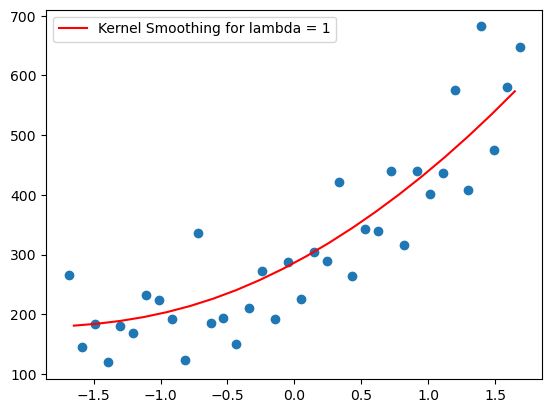

In [23]:
lam = 1

model = KernelRegressionGradient(GaussianKernel, lam)

# compute the model coordinates
xModel = scale([i for i in range(20)])
yModel = [model.predict(i, trainX, trainY, [0, 0], alpha = 0.001, h = 0.0001, tolerance = 0.01, maxIterations = 100000) for i in xModel]

# plot the model
label = 'Kernel Smoothing for lambda = ' + str(np.round(lam, 2))
plt.scatter(X, y)
plt.plot(xModel, yModel, 'r', label = label)
plt.legend()
    
# apply the functions to the test data and predict with the model
trainPredictions = [model.predict(i, trainX, trainY, [0, 0], alpha = 0.001, h = 0.0001, tolerance = 0.01, maxIterations = 100000) for i in trainX]
testPredictions = [model.predict(i, trainX, trainY, [0, 0], alpha = 0.001, h = 0.0001, tolerance = 0.01, maxIterations = 100000) for i in testX]
    
# compute the training and test mean absolute error
trainError = mean_absolute_error(trainY, trainPredictions)
testError = mean_absolute_error(testY, testPredictions)
    
# return quality metrics
print('lambda:', np.round(lam, 3), '\t\tr^2:', np.round(r2_score(trainY, trainPredictions), 3),
      '\t\ttrain MAE:', np.round(trainError, 3), '\t\ttest MAE:', np.round(testError, 3))

We could run it like last time (below), but it becomes **very** expensive.

0


C:\Users\rwhite\AppData\Local\Temp\ipykernel_29844\1147545522.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.array([1, float(x0)]) @ self.theta


lambda: 0.6 		r^2: 0.739 		train MAE: 56.185 		test MAE: 44.689
1


C:\Users\rwhite\AppData\Local\Temp\ipykernel_29844\1147545522.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.array([1, float(x0)]) @ self.theta


lambda: 0.7 		r^2: 0.801 		train MAE: 52.886 		test MAE: 43.425
2


C:\Users\rwhite\AppData\Local\Temp\ipykernel_29844\1147545522.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.array([1, float(x0)]) @ self.theta


lambda: 0.8 		r^2: 0.8 		train MAE: 52.851 		test MAE: 41.338
3


C:\Users\rwhite\AppData\Local\Temp\ipykernel_29844\1147545522.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.array([1, float(x0)]) @ self.theta


lambda: 0.9 		r^2: 0.789 		train MAE: 54.078 		test MAE: 40.68
4


C:\Users\rwhite\AppData\Local\Temp\ipykernel_29844\1147545522.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.array([1, float(x0)]) @ self.theta


lambda: 1.0 		r^2: 0.781 		train MAE: 54.857 		test MAE: 40.303
5


C:\Users\rwhite\AppData\Local\Temp\ipykernel_29844\1147545522.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.array([1, float(x0)]) @ self.theta


lambda: 1.1 		r^2: 0.773 		train MAE: 55.682 		test MAE: 40.516
6


C:\Users\rwhite\AppData\Local\Temp\ipykernel_29844\1147545522.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.array([1, float(x0)]) @ self.theta


lambda: 1.2 		r^2: 0.765 		train MAE: 56.415 		test MAE: 40.664
7


C:\Users\rwhite\AppData\Local\Temp\ipykernel_29844\1147545522.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.array([1, float(x0)]) @ self.theta


lambda: 1.3 		r^2: 0.757 		train MAE: 57.047 		test MAE: 41.049
8


C:\Users\rwhite\AppData\Local\Temp\ipykernel_29844\1147545522.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.array([1, float(x0)]) @ self.theta


lambda: 1.4 		r^2: 0.75 		train MAE: 57.743 		test MAE: 41.512
9


C:\Users\rwhite\AppData\Local\Temp\ipykernel_29844\1147545522.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.array([1, float(x0)]) @ self.theta


lambda: 1.5 		r^2: 0.743 		train MAE: 58.335 		test MAE: 41.892
10


C:\Users\rwhite\AppData\Local\Temp\ipykernel_29844\1147545522.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.array([1, float(x0)]) @ self.theta


lambda: 1.6 		r^2: 0.737 		train MAE: 58.841 		test MAE: 42.208
11


C:\Users\rwhite\AppData\Local\Temp\ipykernel_29844\1147545522.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.array([1, float(x0)]) @ self.theta


lambda: 1.7 		r^2: 0.732 		train MAE: 59.274 		test MAE: 42.474
12


C:\Users\rwhite\AppData\Local\Temp\ipykernel_29844\1147545522.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.array([1, float(x0)]) @ self.theta


lambda: 1.8 		r^2: 0.727 		train MAE: 59.647 		test MAE: 42.7
13


C:\Users\rwhite\AppData\Local\Temp\ipykernel_29844\1147545522.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.array([1, float(x0)]) @ self.theta


lambda: 1.9 		r^2: 0.722 		train MAE: 59.984 		test MAE: 42.894
14


C:\Users\rwhite\AppData\Local\Temp\ipykernel_29844\1147545522.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.array([1, float(x0)]) @ self.theta


lambda: 2.0 		r^2: 0.718 		train MAE: 60.455 		test MAE: 43.061


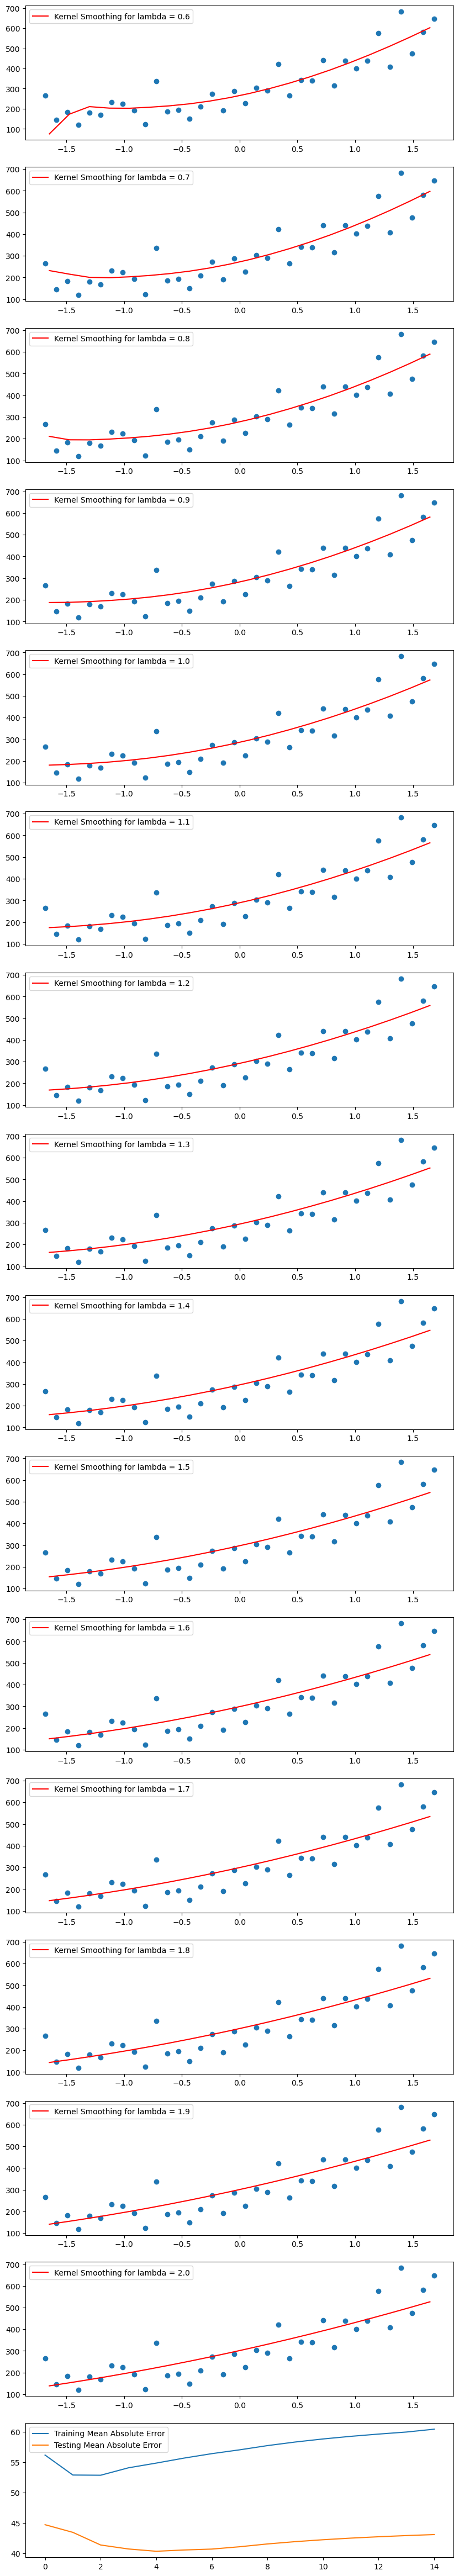

In [24]:
lamValues = np.linspace(0.6, 2, 15)

M = lamValues.shape[0]

# allow multiple plots
fig, axes = plt.subplots(nrows = M + 1, figsize = (10, 4*M))

trainMAE = []
testMAE = []

for (j, lam) in enumerate(lamValues):
    print(j)
    model = KernelRegressionGradient(GaussianKernel, lam)

    # compute the model coordinates
    xModel = scale([i for i in range(20)])
    yModel = [model.predict(i, trainX, trainY, [0, 0], alpha = 0.001, h = 0.0001, tolerance = 0.01,
                            maxIterations = 100000) for i in xModel]

    # plot the model
    label = 'Kernel Smoothing for lambda = ' + str(np.round(lam, 2))
    axes[j].scatter(X, y)
    axes[j].plot(xModel, yModel, 'r', label = label)
    axes[j].legend()
    
    # apply the functions to the test data and predict with the model
    trainPredictions = [model.predict(i, trainX, trainY, [0, 0], alpha = 0.001, h = 0.0001,
                                      tolerance = 0.01, maxIterations = 100000) for i in trainX]
    testPredictions = [model.predict(i, trainX, trainY, [0, 0], alpha = 0.001, h = 0.0001,
                                     tolerance = 0.01, maxIterations = 100000) for i in testX]
    
    # compute the training and test mean absolute error
    trainError = mean_absolute_error(trainY, trainPredictions)
    testError = mean_absolute_error(testY, testPredictions)
    
    # save the training and test mean absolute error
    trainMAE.append(trainError)
    testMAE.append(testError)

    # return quality metrics
    print('lambda:', np.round(lam, 3), '\t\tr^2:', np.round(r2_score(trainY, trainPredictions), 3),
          '\t\ttrain MAE:', np.round(trainError, 3), '\t\ttest MAE:', np.round(testError, 3))
    
# plot the errors
axes[M].plot(range(M), trainMAE, label = 'Training Mean Absolute Error')
axes[M].plot(range(M), testMAE, label = 'Testing Mean Absolute Error')
axes[M].legend()